# How does AIS length and channel distribution affect AP firing properties in a Model of a mitral cell?

In [1]:
import sys
import scipy.signal as s
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
#%matplotlib notebook
sys.path.insert(0,"../mitral_cell/")
from neuron import h
# custom modules
from mitralcell import MitralCell
import actionpotential as ap


mpl.rcParams['font.size'] = 14
mpl.rcParams['font.weight'] = 'bold'
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['legend.loc'] = 'upper right'
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['legend.fancybox'] = False
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['axes.linewidth']= 1
mpl.rcParams['axes.titleweight']= 'normal'
CMAP = "viridis"

def make_cmap(time_v, cmap):
    lt = len(time_v)
    cm = plt.get_cmap(cmap, lt)
    return [cm(i/(lt+1)) for i in range(lt)]
    

In [2]:

h.nrn_load_dll("../../nmodl/x86_64/.libs/libnrnmech.so")

cell = MitralCell("1", nodes=5)


In [3]:
h.topology()



|---|       soma(0-1)
     `--------------|       ais(0-1)
                     `---------|       myelin_seg_0(0-1)
                                `--|       node_0(0-1)
                                    `---------|       myelin_seg_1(0-1)
                                               `--|       node_1(0-1)
                                                   `---------|       myelin_seg_2(0-1)
                                                              `--|       node_2(0-1)
                                                                  `---------|       myelin_seg_3(0-1)
                                                                             `--|       node_3(0-1)
                                                                                 `---------|       myelin_seg_4(0-1)
                                                                                            `--|       node_4(0-1)
                                                                                

1.0

# Running experiments

To run batch experiments, I use python's dictionary datastructure to set all the relevant experimental parameters. Dictionaries are flexible, easy to parse, and easy to represent as JSON for serialization and documentation. 
The dictionary would look like this:
```python
stim_details = {
    'experiment_temperature': 36,
    'dur':5,
    'delay':5,
    'amp':0.07,
    'loc':0.5,
    'rmp':-65,
    'run_dur': 80,
    'thing_to_stim':'dend',
    'recording_vectors': {}}

```

and would be passed to a special method defined in my cell which parses the experiment details, and runs the experiment. 

`thing_to_stim` and `loc` defines where the **IClamp** will be placed for stimulation, and `recording_vectors` holds a dictionary of **NEURON** vectors for recording from different locations. A time vector is automatically recorded and returned.
After the experiment is run, this same data structure is returned with the results in the `recording_vectors` dictionary. 

# Experiment 1:
How does stimulation intensity affect AP shape and amplitude at the AIS vs soma?

In [4]:
stim_details = {
    'experiment_temperature': 36,
    'dur':5,
    'delay':5,
    'amp':0.07,
    'loc':0.5,
    'rmp':-65,
    'run_dur': 80,
    'thing_to_stim':'dend',
    'recording_vectors': {}}

ais_data = []
soma_data = []
time_vectors = []
amplitudes = []

for amp in np.arange(-0.025,0.3,0.025):
    amplitudes.append(amp) # record amplitude
    stim_details['amp'] = amp # set amplitude in experiment dictionary
    stim_details['recording_vectors']['soma'] = h.Vector().record(cell.soma(0.5)._ref_v) # record from soma
    stim_details['recording_vectors']['ais'] = h.Vector().record(cell.ais(0.5)._ref_v) # record from AIS
    cell.add_stim(stim_details) # load and set experiment metadata to run
    res = cell.run() # run experiment
    ais_data.append(res['recording_vectors']['ais']) # save the AIS voltage vector
    soma_data.append(res['recording_vectors']['soma']) # save the AIS voltage vector
    time_vectors.append(res['recording_vectors']['t']) # save the time vectors

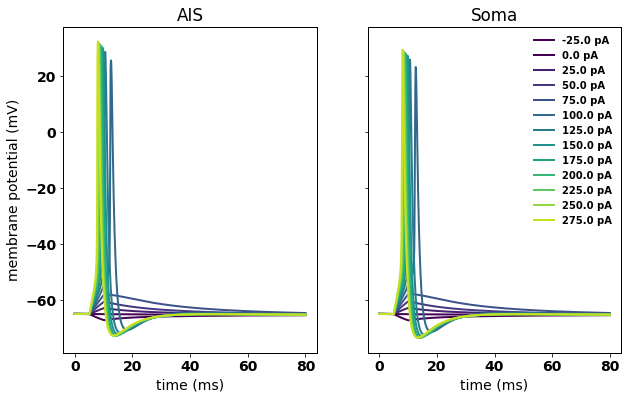

In [5]:
colors = make_cmap(time_vectors, CMAP)

f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6), sharex=True, sharey=True)
for time, ais, soma, amp, clr in zip(time_vectors, ais_data, soma_data, amplitudes, colors):    
    ax1.plot(time, ais, color=clr)
    ax2.plot(time, soma, color=clr, 
             label = f"{np.round(amp*1000, 2)} pA")
    
ax1.set_title("AIS")
ax1.set_ylabel("membrane potential (mV)")
ax1.set_xlabel("time (ms)")
ax2.set_xlabel("time (ms)")
ax2.set_title("Soma")

ax2.legend()

In [6]:
ais_amps, ais_fwhms = ap.ap_batch_amp_and_fwhm(time_vectors, ais_data, stim_details['rmp'])
soma_amps, soma_fwhms = ap.ap_batch_amp_and_fwhm(time_vectors, soma_data, stim_details['rmp'])
pa_amps = [i*1000 for i in amplitudes]

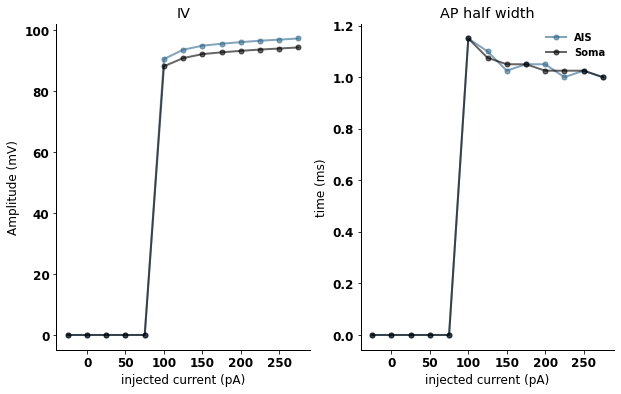

In [7]:
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.weight'] = 'bold'
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6), sharex=True, sharey=False)
ax1.plot(pa_amps, ais_amps, color=colors[5], marker=".", markersize=10, alpha=0.6)
ax1.plot(pa_amps, soma_amps, color="black", marker=".",  markersize=10, alpha=0.6)
ax2.plot(pa_amps, ais_fwhms, label = f"AIS", color=colors[5], marker=".", markersize=10, alpha=0.6)
ax2.plot(pa_amps, soma_fwhms, label = f"Soma", color="black",  marker=".", markersize=10, alpha=0.6)
ax1.set_title("IV")
ax1.set_ylabel("Amplitude (mV)")
ax2.set_ylabel("time (ms)")
ax1.set_xlabel("injected current (pA)")
ax2.set_xlabel("injected current (pA)")
ax2.set_title("AP half width")
ax2.legend(loc="best")
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

# Experiment 2: How does AIS length affect amplitude?

Here I am just changing AIS length while keeping channel distributions the same

In [8]:
# make a new cell
cell2 = MitralCell("2", nodes=5)

In [9]:
stim_details_len = {
    'experiment_temperature': 36,
    'dur':5,
    'delay':5,
    'amp':0.08,
    'loc':0.5,
    'rmp':-65,
    'run_dur': 80,
    'thing_to_stim':'dend',
    'recording_vectors': {}}

ais_len_data = []
soma_len_data = []
time_vectors = []
lengths = []

for length in np.arange(30,70,5):
    lengths.append(length) 
    cell2.ais.L = length
    stim_details_len['recording_vectors']['soma'] = h.Vector().record(cell2.soma(0.5)._ref_v) # record from soma
    stim_details_len['recording_vectors']['ais'] = h.Vector().record(cell2.ais(0.5)._ref_v) # record from AIS
    cell2.add_stim(stim_details_len)
    res = cell2.run() # run experiment
    ais_len_data.append(res['recording_vectors']['ais']) # save the AIS voltage vector
    soma_len_data.append(res['recording_vectors']['soma']) # save the AIS voltage vector
    time_vectors.append(res['recording_vectors']['t']) # save the time vectors

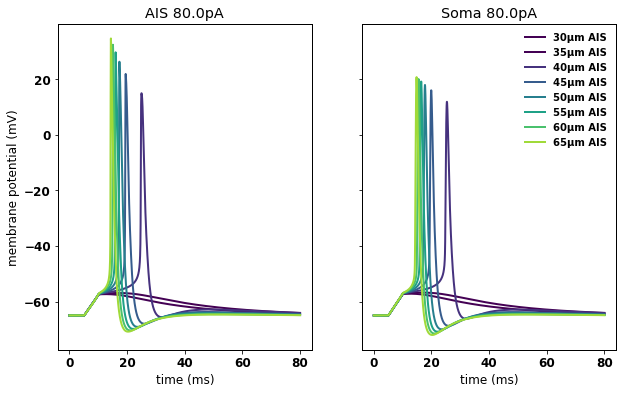

In [10]:
colors = make_cmap(time_vectors, CMAP)
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6), sharex=True, sharey=True)
for time, ais, soma, length, col in zip(time_vectors, ais_len_data, soma_len_data, lengths, colors):    
    ax1.plot(time, ais, color=col)
    ax2.plot(time, soma, color=col, label=f"{length}\u00B5m AIS")
    
ax1.set_title(f"AIS {stim_details_len['amp']*1000}pA")
ax1.set_ylabel("membrane potential (mV)")
ax1.set_xlabel("time (ms)")
ax2.set_xlabel("time (ms)")
ax2.set_title(f"Soma {stim_details_len['amp']*1000}pA")

ax2.legend()

In [11]:
ais_len_amps, ais_len_fwhms = ap.ap_batch_amp_and_fwhm(time_vectors, ais_len_data, stim_details_len['rmp'])
soma_len_amps, soma_len_fwhms = ap.ap_batch_amp_and_fwhm(time_vectors, soma_len_data, stim_details_len['rmp'])

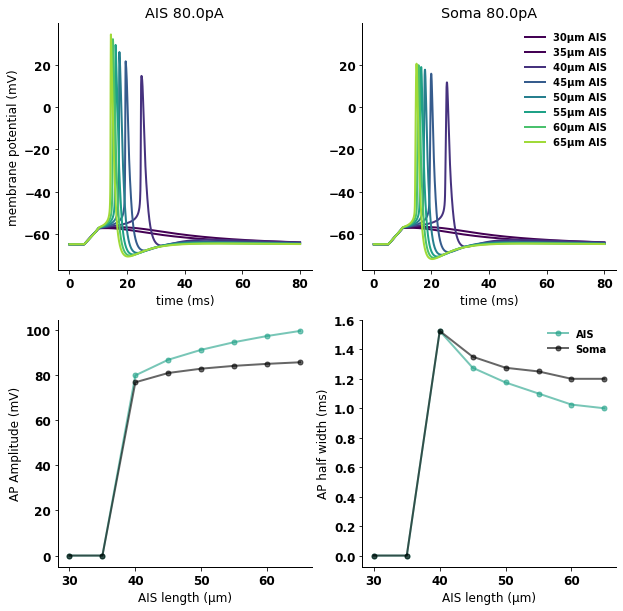

In [12]:
colors = make_cmap(time_vectors, CMAP)
f = plt.figure(figsize=(10,10))
ax1 = f.add_subplot(221)
ax2 = f.add_subplot(222, sharex=ax1, sharey=ax1)
ax3 = f.add_subplot(223)
ax4 = f.add_subplot(224, sharex=ax3)

for time, ais, soma, length, col in zip(time_vectors, ais_len_data, soma_len_data, lengths, colors):
    ax1.plot(time, ais, color=col)
    ax2.plot(time, soma, color=col, label=f"{length}\u00B5m AIS")

ax3.plot(lengths, ais_len_amps, color=colors[5], marker=".", markersize=10, alpha=0.6)
ax3.plot(lengths, soma_len_amps, color="black", marker=".",  markersize=10, alpha=0.6)
ax4.plot(lengths, ais_len_fwhms, label = f"AIS", color=colors[5], marker=".", markersize=10, alpha=0.6)
ax4.plot(lengths, soma_len_fwhms, label = f"Soma", color="black",  marker=".", markersize=10, alpha=0.6)

ax1.set_title(f"AIS {stim_details_len['amp']*1000}pA")
ax1.set_ylabel("membrane potential (mV)")
ax1.set_xlabel("time (ms)")
ax2.set_xlabel("time (ms)")
ax2.set_title(f"Soma {stim_details_len['amp']*1000}pA")

ax2.legend()

ax3.set_ylabel("AP Amplitude (mV)")
ax4.set_ylabel("AP half width (ms)")
ax3.set_xlabel("AIS length (\u00B5m)")
ax4.set_xlabel("AIS length (\u00B5m)")
ax4.legend(loc="best")
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

# Experiment 3: Changing Na<sub>v</sub>1.6 distribution along the AIS

In [13]:
stim_details_cond = {
    'experiment_temperature': 36,
    'dur':5,
    'delay':5,
    'amp':0.08,
    'loc':0.5,
    'rmp':-65,
    'run_dur': 80,
    'thing_to_stim':'dend',
    'recording_vectors': {}}

ais16_data = []
soma16_data = []
time_vectors = []
cond_maxs = []

cell2.gnav16_dist['max'] = 2500
cell2.gnav12_dist['max'] = 2000
cell2.setup_biophysics()

for nav16max in np.arange(0,6000,500):
    cond_maxs.append(nav16max) 
    cell2.gnav16_dist['max'] = nav16max
    stim_details_cond['recording_vectors']['soma'] = h.Vector().record(cell2.soma(0.5)._ref_v) # record from soma
    stim_details_cond['recording_vectors']['ais'] = h.Vector().record(cell2.ais(0.5)._ref_v) # record from AIS
    cell2.add_stim(stim_details_cond)
    res = cell2.run() # run experiment
    ais16_data.append(res['recording_vectors']['ais']) # save the AIS voltage vector
    soma16_data.append(res['recording_vectors']['soma']) # save the AIS voltage vector
    time_vectors.append(res['recording_vectors']['t']) # save the time vectors
    
ais16_cond_amps, ais16_cond_fwhms = ap.ap_batch_amp_and_fwhm(time_vectors, ais16_data, stim_details_cond['rmp'])
soma16_cond_amps, soma16_cond_fwhms = ap.ap_batch_amp_and_fwhm(time_vectors, soma16_data, stim_details_cond['rmp'])

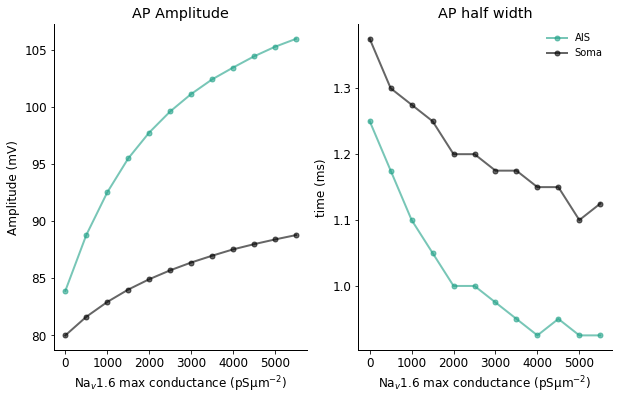

In [14]:
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['mathtext.bf']= 'none'
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6), sharex=True, sharey=False)
ax1.plot(cond_maxs, ais16_cond_amps, color=colors[5], marker=".", markersize=10, alpha=0.6)
ax1.plot(cond_maxs, soma16_cond_amps, color="black", marker=".",  markersize=10, alpha=0.6)
ax2.plot(cond_maxs, ais16_cond_fwhms, label = f"AIS", color=colors[5], marker=".", markersize=10, alpha=0.6)
ax2.plot(cond_maxs, soma16_cond_fwhms, label = f"Soma", color="black",  marker=".", markersize=10, alpha=0.6)
ax1.set_title("AP Amplitude")
ax1.set_ylabel("Amplitude (mV)")
ax2.set_ylabel("time (ms)")
ax1.set_xlabel("Na$_{v}$1.6 max conductance (pS\u00B5m$^{-2}$)")
ax2.set_xlabel("Na$_{v}$1.6 max conductance (pS\u00B5m$^{-2}$)")
ax2.set_title("AP half width")
ax2.legend(loc="best")
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

# Experiment 3: Changing Na<sub>v</sub>1.2 distribution along the AIS

In [15]:
stim_details_cond = {
    'experiment_temperature': 36,
    'dur':5,
    'delay':5,
    'amp':0.08,
    'loc':0.5,
    'rmp':-65,
    'run_dur': 80,
    'thing_to_stim':'dend',
    'recording_vectors': {}}

ais12_data = []
soma12_data = []
time_vectors = []
cond_maxs = []

cell2.gnav16_dist['max'] = 2500
cell2.gnav12_dist['max'] = 2000
cell2.setup_biophysics()

for nav12max in np.arange(0,6000,500):
    cond_maxs.append(nav12max) 
    cell2.gnav12_dist['max'] = nav12max
    stim_details_cond['recording_vectors']['soma'] = h.Vector().record(cell2.soma(0.5)._ref_v) # record from soma
    stim_details_cond['recording_vectors']['ais'] = h.Vector().record(cell2.ais(0.5)._ref_v) # record from AIS
    cell2.add_stim(stim_details_cond)
    res = cell2.run() # run experiment
    ais12_data.append(res['recording_vectors']['ais']) # save the AIS voltage vector
    soma12_data.append(res['recording_vectors']['soma']) # save the AIS voltage vector
    time_vectors.append(res['recording_vectors']['t']) # save the time vectors
    

ais12_cond_amps, ais12_cond_fwhms = ap.ap_batch_amp_and_fwhm(time_vectors, ais12_data, stim_details_cond['rmp'])
soma12_cond_amps, soma12_cond_fwhms = ap.ap_batch_amp_and_fwhm(time_vectors, soma12_data, stim_details_cond['rmp'])

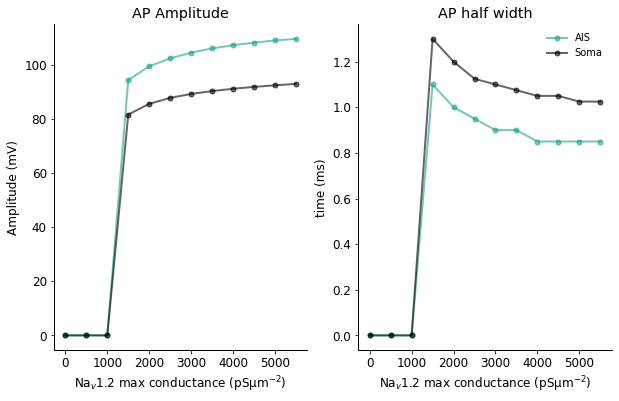

In [16]:
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['mathtext.bf']= 'none'
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6), sharex=True, sharey=False)
ax1.plot(cond_maxs, ais12_cond_amps, color=colors[5], marker=".", markersize=10, alpha=0.6)
ax1.plot(cond_maxs, soma12_cond_amps, color="black", marker=".",  markersize=10, alpha=0.6)
ax2.plot(cond_maxs, ais12_cond_fwhms, label = f"AIS", color=colors[5], marker=".", markersize=10, alpha=0.6)
ax2.plot(cond_maxs, soma12_cond_fwhms, label = f"Soma", color="black",  marker=".", markersize=10, alpha=0.6)
ax1.set_title("AP Amplitude")
ax1.set_ylabel("Amplitude (mV)")
ax2.set_ylabel("time (ms)")
ax1.set_xlabel("Na$_{v}$1.2 max conductance (pS\u00B5m$^{-2}$)")
ax2.set_xlabel("Na$_{v}$1.2 max conductance (pS\u00B5m$^{-2}$)")
ax2.set_title("AP half width")
ax2.legend(loc="best")
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

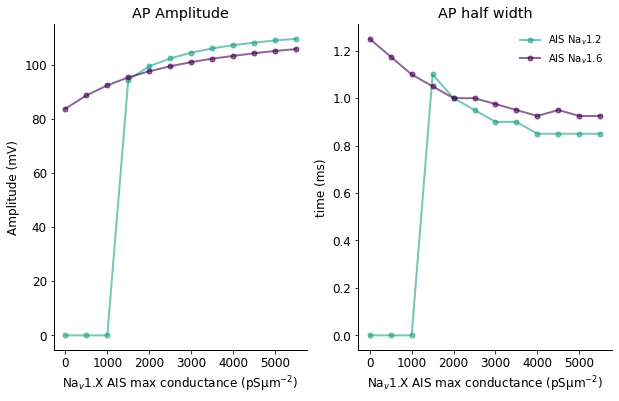

In [17]:
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['mathtext.bf']= 'none'

f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6), sharex=True, sharey=False)
ax1.plot(cond_maxs, ais12_cond_amps, label= "AIS Na$_{v}$1.2", color=colors[5], marker=".", markersize=10, alpha=0.6)
ax1.plot(cond_maxs, ais16_cond_amps, label= "AIS Na$_{v}$1.6", color=colors[0], marker=".", markersize=10, alpha=0.6)
ax2.plot(cond_maxs, ais12_cond_fwhms, label = "AIS Na$_{v}$1.2", color=colors[5], marker=".", markersize=10, alpha=0.6)
ax2.plot(cond_maxs, ais16_cond_fwhms, label = "AIS Na$_{v}$1.6", color=colors[0], marker=".", markersize=10, alpha=0.6)

ax1.set_title("AP Amplitude")
ax1.set_ylabel("Amplitude (mV)")
ax2.set_ylabel("time (ms)")
ax1.set_xlabel("Na$_{v}$1.X AIS max conductance (pS\u00B5m$^{-2}$)")
ax2.set_xlabel("Na$_{v}$1.X AIS max conductance (pS\u00B5m$^{-2}$)")
ax2.set_title("AP half width")
ax2.legend(loc="best")
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

# Experiment 4: K<sub>v</sub> distributions

In [18]:
stim_details_kv = {
    'experiment_temperature': 36,
    'dur':5,
    'delay':5,
    'amp':0.1,
    'loc':0.5,
    'rmp':-65,
    'run_dur': 80,
    'thing_to_stim':'dend',
    'recording_vectors': {}}

aisk_data = []
somak_data = []
time_vectors = []
kvs = []

cell2.gnav16_dist['max'] = 2500
cell2.gnav12_dist['max'] = 2000
cell2.ais_kv_gbar = 100
cell2.setup_biophysics()

for kv in np.arange(0,1000,100):
    kvs.append(kv) 
    cell2.ais_kv_gbar = kv
    stim_details_cond['recording_vectors']['soma'] = h.Vector().record(cell2.soma(0.5)._ref_v) # record from soma
    stim_details_cond['recording_vectors']['ais'] = h.Vector().record(cell2.ais(0.5)._ref_v) # record from AIS
    cell2.add_stim(stim_details_cond)
    res = cell2.run() # run experiment
    aisk_data.append(res['recording_vectors']['ais']) # save the AIS voltage vector
    somak_data.append(res['recording_vectors']['soma']) # save the AIS voltage vector
    time_vectors.append(res['recording_vectors']['t']) # save the time vectors
    

aisk_cond_amps, aisk_cond_fwhms = ap.ap_batch_amp_and_fwhm(time_vectors, aisk_data, stim_details_cond['rmp'])
somak_cond_amps, somak_cond_fwhms = ap.ap_batch_amp_and_fwhm(time_vectors, somak_data, stim_details_cond['rmp'])

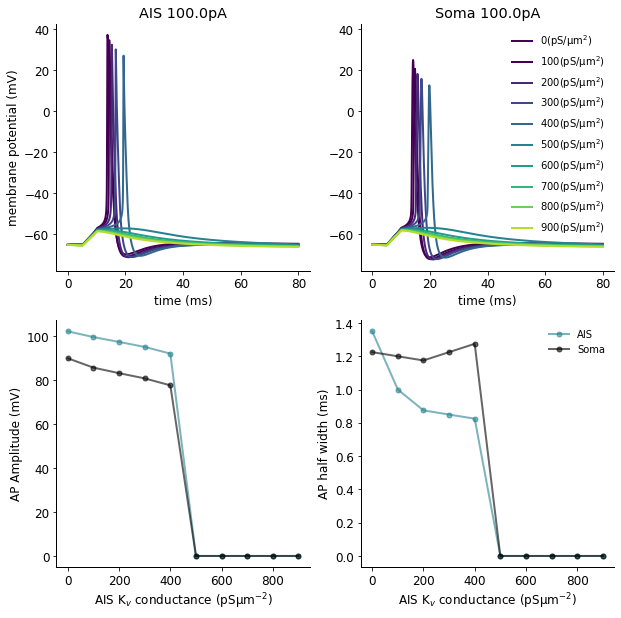

In [19]:
colors = make_cmap(time_vectors, CMAP)
f = plt.figure(figsize=(10,10))
ax1 = f.add_subplot(221)
ax2 = f.add_subplot(222, sharex=ax1, sharey=ax1)
ax3 = f.add_subplot(223)
ax4 = f.add_subplot(224, sharex=ax3)

for time, ais, soma, kv, col in zip(time_vectors, aisk_data, somak_data, kvs, colors):
    ax1.plot(time, ais, color=col)
    ax2.plot(time, soma, color=col, label = "{}(pS/\u00B5m$^2$)".format(kv))

ax3.plot(kvs, aisk_cond_amps, color=colors[5], marker=".", markersize=10, alpha=0.6)
ax3.plot(kvs, somak_cond_amps, color="black", marker=".",  markersize=10, alpha=0.6)
ax4.plot(kvs, aisk_cond_fwhms, label = f"AIS", color=colors[5], marker=".", markersize=10, alpha=0.6)
ax4.plot(kvs, somak_cond_fwhms, label = f"Soma", color="black",  marker=".", markersize=10, alpha=0.6)

ax1.set_title(f"AIS {stim_details_kv['amp']*1000}pA")
ax1.set_ylabel("membrane potential (mV)")
ax1.set_xlabel("time (ms)")
ax2.set_xlabel("time (ms)")
ax2.set_title(f"Soma {stim_details_kv['amp']*1000}pA")

ax2.legend()

ax3.set_ylabel("AP Amplitude (mV)")
ax4.set_ylabel("AP half width (ms)")
ax3.set_xlabel("AIS K$_{v}$ conductance (pS\u00B5m$^{-2}$)")
ax4.set_xlabel("AIS K$_{v}$ conductance (pS\u00B5m$^{-2}$)")
ax4.legend(loc="best")
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

# future experiments:
1. How do changes in AIS parameters affect node of Ranvier propagation?
1. How do AP's change as they travel along realistic LOT axons?